In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)


In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

/Users/lin_peihsuan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 10s 201us/step - loss: 1.7564 - acc: 0.3899 - val_loss: 1.8502 - val_acc: 0.3684
Epoch 3/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.6227 - acc: 0.4331 - val_loss: 1.7371 - val_acc: 0.3927
Epoch 4/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.5487 - acc: 0.4588 - val_loss: 1.6372 - val_acc: 0.4281
Epoch 5/10
50000/50000 [==============================] - 11s 216us/step - loss: 1.4903 - acc: 0.4792 - val_loss: 1.5844 - val_acc: 0.4421
Epoch 6/10
50000/50000 [==============================] - 13s 253us/step - loss: 1.4433 - acc: 0.4961 - val_loss: 1.5648 - val_acc: 0.4535
Epoch 7/10
50000/50000 [==============================] - 13s 261us/step - loss: 1.4039 - acc: 0.5105 - val_loss: 1.5436 - val_acc: 0.4573
Epoch 8/10
50000/50000 [==============================] - 10s 190us/step - loss: 1.3675 - acc: 0.5233 - val_loss: 1.5536 - val_acc: 0.4519
Epoch 9/10
50000/50000 [==============

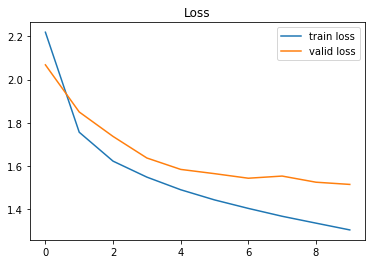

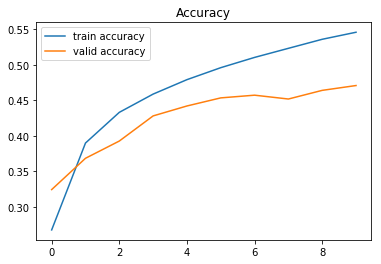

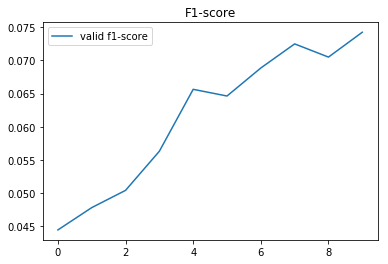

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

In [11]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
train, test = keras.datasets.cifar10.load_data()

In [13]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [14]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [22]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [23]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [24]:
# 載入 Callbacks
from keras.callbacks import Callback
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_tp"] = np.sum(np.logical_and(y_true == 1, y_pred == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_true == 0, y_pred == 0))
        
rec_tptn = Record_tp_tn()

In [25]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
__________

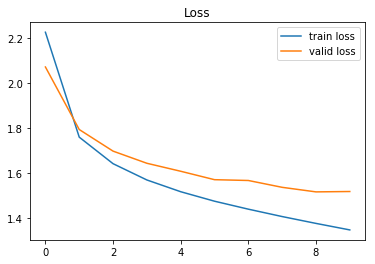

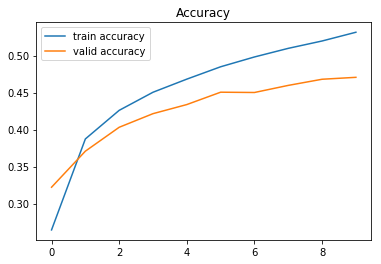

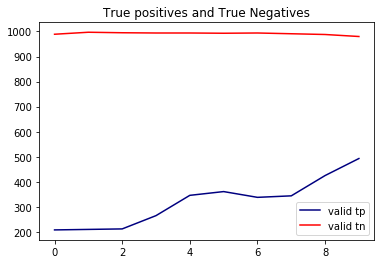

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()